In [5]:
# Run this block to install dependencies [Remember to make the statement true]
if 0 == 1:
    !pip3 install pandas
    !pip3 install tqdm
    !pip3 install scikit-learn
    !pip3 install gensim
    !pip3 install spacy
    !python3 -m spacy download en
    !pip3 install numpy

In [6]:
import pandas as pd
import spacy
import pickle
from tqdm import tqdm
from gensim.corpora import Dictionary
from sklearn.utils import shuffle
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

nlp = spacy.load('en')
DATA_LIMIT = 1000

df = pd.read_csv('./imdb_master.csv', encoding='latin1')
df_neg = df[df['label'] == 'neg']
df_pos = df[df['label'] == 'pos']
df = pd.concat((df_pos[:DATA_LIMIT], df_neg[:DATA_LIMIT]))
df_test=pd.concat((df_pos[1000:1500], df_neg[1000:1500]))
def process_text(input_string, return_string=False, stem=False):
    text = nlp(u'' + input_string)
    if stem == True:
        text = [tok.lemma_ for tok in text if (tok.is_alpha and not tok.is_stop)]
    else:
        text = [tok.lower_ for tok in text if (tok.is_alpha and not tok.is_stop)]
    if return_string == True:
        return " ".join(text)
    return text

In [10]:
# Make this statement true to run from scratch [It takes time to process the text]
if 1 != 0:
    wordlist = []
    for i in tqdm(range(df.shape[0])):
        wordlist.append(process_text(df['review'].iloc[i]))
        
    with open('vocabulary.txt', 'wb') as vocabulary:
        pickle.dump(wordlist, vocabulary)
    vocabulary.close()

100%|██████████████████████████████████████| 2000/2000 [01:30<00:00, 22.09it/s]


In [11]:
# Load vocabulary
wordlist = []
with open('vocabulary.txt', 'rb') as vocabulary:
    wordlist = pickle.load(vocabulary)

In [12]:
# Keeping track of frequency of a single token
frequency = defaultdict(int)
for text in wordlist:
    for token in text:
        frequency[token] += 1
        
# Apply Threshold to limit the vocabulary size, discarding the tokens which appeard number of times below the threshold limit 
FREQ_THRESHOLD = 35

thresholded_wordlist =  [[token for token in text if frequency[token] > FREQ_THRESHOLD]
          for text in wordlist]

# Create Dictionary based on the word list
dictionary = Dictionary(thresholded_wordlist)

# Number of tokens
print("Number of Tokens - {}".format(len(dictionary)))

Number of Tokens - 1018


In [19]:
dump =""
for i in tqdm(range(2000)):
    dump += df['review'].iloc[i].lower()

100%|████████████████████████████████████| 2000/2000 [00:00<00:00, 4423.83it/s]


In [20]:
with open('dump_fasttext', 'w', encoding ='utf-8') as f:
    for i in range(2000):
        f.write(df['review'].iloc[i].lower())
        
    f.close()

In [21]:
df.head()

,Unnamed: 0,type,review,label,file
12500,12500,test,I went and saw this movie last night after bei...,pos,0_10.txt
12501,12501,test,Actor turned director Bill Paxton follows up h...,pos,10000_7.txt
12502,12502,test,As a recreational golfer with some knowledge o...,pos,10001_9.txt
12503,12503,test,"I saw this film in a sneak preview, and it is ...",pos,10002_8.txt
12504,12504,test,Bill Paxton has taken the true story of the 19...,pos,10003_8.txt


In [22]:
spacy_obj = nlp(u''+dump)

In [ ]:
#spacy_doc = model

In [58]:
word2idx = { dictionary[idx]:idx for idx in range(len(dictionary))}
len(word2idx)

1018

NameError: name 'word2idx' is not defined

In [23]:
len(spacy_obj)

525604

In [25]:
tok5 = spacy_obj[5]

In [26]:
print(tok5)

movie


In [27]:
tok5.nbor(1)

last

In [28]:
tok5.nbor(-1)

this

In [35]:
one_hot = np.zeros((1018,1018))
one_hot.shape

(1018, 1018)

In [59]:
one_hot = np.eye(1018)
print(one_hot)


[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  1. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  1.  0.  0.]
 [ 0.  0.  0. ...,  0.  1.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]]


In [60]:
def getIndex(word):
    try:
        idx = word2idx[word]
    except KeyError:
        idx = -1
    return idx

In [69]:
def input_generation(word):
    ind1 = np.zeros((4))
    ind1[0] = getIndex(str(word.nbor(-2)))
    ind1[1] = getIndex(str(word.nbor(-1)))
    ind1[2] = getIndex(str(word.nbor(1)))
    ind1[3] = getIndex(str(word.nbor(2)))
    return ind1

In [134]:
len(dictionary)

1018

In [135]:
len_s = len(spacy_obj)
inp = np.zeros((len_s,4))
target = np.zeros((len_s))
for i in tqdm(range(len_s-2)):
    token = spacy_obj[i]
    token1 = str(token)
    index = getIndex(token1)
    target[i]=index
    inp[i,:] = input_generation(spacy_obj[i])



100%|███████████████████████████████| 525602/525602 [00:35<00:00, 14864.37it/s]


In [133]:
inp.shape

(525604, 4)

In [121]:
target_pos = target[np.where(target!=-1)[0]]

In [136]:
inp = inp[np.where(target!=-1)[0]]

In [137]:
len(target_pos)
target_pos[0]

21.0

In [138]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

In [139]:
cbow = Sequential()
cbow.add(Embedding(input_dim=1019, output_dim=50, input_length = 4))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(50,)))
cbow.add(Dense(1019, activation = 'softmax'))


In [140]:
cbow.compile(loss='sparse_categorical_crossentropy', optimizer ='adadelta')

In [141]:
train_x = inp+1
train_y = target_pos+1

In [142]:
train_x.shape

(108024, 4)

In [143]:
train_y.shape

(108024,)

In [144]:
np.max(train_y)

1018.0

In [ ]:
cbow.fit(train_x, train_y,batch_size =128,epochs=5)

Epoch 1/5
108024/108024 [==============================] - ETA: 33:28 - loss: 6.92 - ETA: 17:26 - loss: 6.92 - ETA: 11:56 - loss: 6.92 - ETA: 6:06 - loss: 6.9263 - ETA: 4:09 - loss: 6.925 - ETA: 3:10 - loss: 6.925 - ETA: 2:35 - loss: 6.925 - ETA: 2:11 - loss: 6.924 - ETA: 1:54 - loss: 6.924 - ETA: 1:41 - loss: 6.924 - ETA: 1:32 - loss: 6.923 - ETA: 1:24 - loss: 6.923 - ETA: 1:17 - loss: 6.923 - ETA: 1:12 - loss: 6.923 - ETA: 1:07 - loss: 6.922 - ETA: 1:03 - loss: 6.922 - ETA: 1:03 - loss: 6.922 - ETA: 59s - loss: 6.922 - ETA: 56s - loss: 6.92 - ETA: 54s - loss: 6.92 - ETA: 52s - loss: 6.92 - ETA: 49s - loss: 6.92 - ETA: 48s - loss: 6.92 - ETA: 46s - loss: 6.92 - ETA: 44s - loss: 6.92 - ETA: 43s - loss: 6.91 - ETA: 42s - loss: 6.91 - ETA: 40s - loss: 6.91 - ETA: 39s - loss: 6.91 - ETA: 38s - loss: 6.91 - ETA: 37s - loss: 6.91 - ETA: 36s - loss: 6.91 - ETA: 35s - loss: 6.91 - ETA: 34s - loss: 6.91 - ETA: 34s - loss: 6.91 - ETA: 33s - loss: 6.91 - ETA: 32s - loss: 6.91 - ETA: 32s - loss: 

 53760/108024 [=============>................] - ETA: 20s - loss: 6.47 - ETA: 15s - loss: 6.43 - ETA: 16s - loss: 6.47 - ETA: 16s - loss: 6.47 - ETA: 15s - loss: 6.46 - ETA: 15s - loss: 6.46 - ETA: 15s - loss: 6.46 - ETA: 15s - loss: 6.46 - ETA: 15s - loss: 6.47 - ETA: 15s - loss: 6.48 - ETA: 15s - loss: 6.48 - ETA: 15s - loss: 6.47 - ETA: 15s - loss: 6.47 - ETA: 15s - loss: 6.47 - ETA: 15s - loss: 6.47 - ETA: 15s - loss: 6.46 - ETA: 15s - loss: 6.46 - ETA: 15s - loss: 6.46 - ETA: 14s - loss: 6.46 - ETA: 14s - loss: 6.46 - ETA: 14s - loss: 6.46 - ETA: 14s - loss: 6.46 - ETA: 14s - loss: 6.46 - ETA: 14s - loss: 6.46 - ETA: 14s - loss: 6.46 - ETA: 14s - loss: 6.45 - ETA: 14s - loss: 6.46 - ETA: 14s - loss: 6.46 - ETA: 14s - loss: 6.46 - ETA: 14s - loss: 6.45 - ETA: 14s - loss: 6.46 - ETA: 14s - loss: 6.45 - ETA: 14s - loss: 6.46 - ETA: 14s - loss: 6.46 - ETA: 14s - loss: 6.46 - ETA: 14s - loss: 6.46 - ETA: 14s - loss: 6.46 - ETA: 14s - loss: 6.46 - ETA: 13s - loss: 6.45 - ETA: 14s - loss

In [ ]:
for i in range(100):
    token = spacy_obj[i]
    if(i==0):
        inp[i,0]=-1
        inp[i,1]=-1
        inp[i,2]=i+1
        inp[i,3]=i+2
    else if(i==1):
        inp[i,0]=-1
        inp[i,1]=i-1
        inp[i,2]=i+2
        inp[i,3]=i+3
        
    else if(i==)

In [6]:
print(dictionary)

Dictionary(5464 unique tokens: ['able', 'admit', 'ben', 'character', 'comedy']...)


![image](https://i.imgur.com/f1uzTDZ.png)

# TODO

* From the screenshot you can see the implementation of word-cooccurance matrix, based on the tokens from the dictionary, build a word-cooccurance matrix yourself which is $X$. Documentation of gensim [https://radimrehurek.com/gensim/corpora/dictionary.html]
* Apply SVD on $X$
* Reduce Dimension 

![dimen_reduc](https://i.imgur.com/lezB870.png)

* Here Richard is taking only top two dimensions of the vector $U$, recommended size is *50* for now.

![dimen_reduc_u](https://i.imgur.com/TA2Bmsq.png)

* Now we can get a fixed size vector for each word. 

* Try to plot something similar based on the given dataset. In class we will try to implement a logistic regression classifier that can classify positive and negative reviews

In [7]:
len_d=len(dictionary)
X=np.zeros((len_d,len_d))
la=np.linalg
for sen in thresholded_wordlist:
    idx=dictionary.doc2idx(sen)
    for i in idx:
        for j in idx:
            X[i,j]=X[i,j]+1
U,s,Vh = la.svd(X, full_matrices=False)


In [8]:
X[1][0]

3.0

In [9]:
U_new=U[:,:50]

In [10]:
print(U_new.shape)

(5464, 50)


In [11]:
print(Vh.shape)


(5464, 5464)


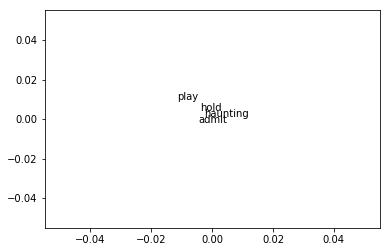

In [12]:
%matplotlib inline
for i in [1, 140, 400, 750]:
    plt.text(U[i,0], U[i,1], dictionary[i])
    plt.axis("tight")

    #how to plot this 

In [14]:
sen2vec(thresholded_wordlist[0])

NameError: name 'sen2vec' is not defined

In [32]:
def sen2vec(sen):
    l=len(sen)
    #X_train=np.zeros()
#     print(l)
    idx=dictionary.doc2idx(sen)
#     print(idx)
    vec=U_new[idx]
#     print(vec)
    total_sum=sum(vec) #feature wise sum (column)
#     avg=total_sum/l
#     print(total_sum)
    
    return total_sum


In [33]:
i=0
# X_train=np.zeros((len(thresholded_wordlist),len(U_new)))
X_train = []
for sen in thresholded_wordlist:
    X_train.append(sen2vec(sen))
    #print(X_train)
    

In [34]:
X_train=np.asarray(X_train)

In [35]:
X_train.shape

(2000, 50)

In [39]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
lr.score(X_train,Y_train)

0.837

In [41]:
def testDataGen():
    wordlist_test = []
    for i in tqdm(range(df_test.shape[0])):
        wordlist_test.append(process_text(df_test['review'].iloc[i]))        
    return wordlist_test

In [42]:
wordlist_test=testDataGen()
X_test = []
for sen in wordlist_test:
    X_test.append(sen2vec(sen))
X_test=np.asarray(X_test)
Y_test=np.concatenate((np.ones(500), np.zeros(500)))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 70.96it/s]


In [43]:
X_test.shape

(1000, 50)

In [44]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
y_pred = lr.predict(X_test)

In [46]:
lr.score(X_test,Y_test)

0.726

In [47]:
from sklearn.metrics import confusion_matrix

In [49]:
confusion_matrix(Y_test,y_pred)

array([[430,  70],
       [204, 296]], dtype=int64)

In [41]:
U_new.shape

NameError: name 'U_new' is not defined

In [42]:
import sys
sys.version

'3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]'

In [43]:
spacy.__version__

'1.9.0'